In [1]:
# imports
import pandas as pd
import numpy as np
from scipy import stats
import string
import math
import sys
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support
from sklearn.datasets import load_digits
from sklearn.metrics import classification_report
from sklearn.tree import export_graphviz
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import make_scorer, recall_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
#Features Importance
def compute_feature_importance(voting_clf, features, weights):
    """ Function to compute feature importance of Voting Classifier """
    
    feature_importance = dict()
    for est in voting_clf.estimators_:
        if hasattr(est, 'feature_importances_'):
            feature_importance[str(est)] = est.feature_importances_
    
    fe_scores = [0]*len(list(feature_importance.values())[0])
    for idx, imp_score in enumerate(feature_importance.values()):
        imp_score_with_weight = imp_score*weights[idx]
        fe_scores = list(np.add(fe_scores, list(imp_score_with_weight)))
        
    df_importace = pd.DataFrame()
    df_importace['Feature'] = features.columns
    df_importace['Feature Importance'] = fe_scores
    print(df_importace.sort_values('Feature Importance', ascending=False))

    feats = {} # a dict to hold feature_name: feature_importance
    for feature, importance in zip(features.columns, fe_scores):
        feats[feature] = importance #add the name/value pair 

    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'importance'})
    importances.sort_values(by='importance').plot(kind='bar', grid=True, figsize=(18,9))

In [3]:
#Features coef
def compute_feature_coef(voting_clf, features, weights):
    """ Function to compute coef of Voting Classifier """
    
    feature_importance = dict()
    for est in voting_clf.estimators_:
        if hasattr(est, 'coef_'):
            feature_importance[str(est)] = np.reshape(est.coef_, features.columns.size)
    
    fe_scores = [0]*len(list(feature_importance.values())[0])
    for idx, imp_score in enumerate(feature_importance.values()):
        imp_score_with_weight = imp_score*weights[idx]
        fe_scores = list(np.add(fe_scores, list(imp_score_with_weight)))
            
    df_importace = pd.DataFrame()
    df_importace['Feature'] = features.columns
    df_importace['Feature Importance'] = fe_scores
    print(df_importace.sort_values('Feature Importance', ascending=False))

    feats = {} # a dict to hold feature_name: feature_importance
    for feature, importance in zip(features.columns, fe_scores):
        feats[feature] = importance #add the name/value pair 

    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'coef'})
    importances.sort_values(by='coef').plot(kind='bar', grid=True, figsize=(18,9))

In [4]:
#Model Scores
def voting_model_scores(voting_clf, X_test, Y_test):
    """ Function to compute scores of models of Voting Classifier """
    plt.figure(figsize=(10, 10))
    j = 0
    for est in voting_clf.estimators_: 
        # Predict using model
        y_predict = est.predict(X_test)
    
        print(est)
        print("Accuracy:", accuracy_score(Y_test,y_predict))
        plot_confusion_matrix(est,X_test,Y_test)
        # performances
        target_names = ['OLA', 'Violation']
        print(classification_report(Y_test, y_predict, target_names=target_names))

In [5]:
def predictResults(model, x, y, y_predict):
    
    # Predict the values by using all test data
    if isinstance(y_predict, int):
        if (y_predict == 0):
            y_predict = model.predict(x)
    plot_confusion_matrix(model, x, y)
    # performances
    target_names = ['OLA', 'Violation']
    print(classification_report(y, y_predict, target_names=target_names))
    # Calculate the score of the model in test data
    print("Accuracy: ", accuracy_score(y, y_predict))
    # Calculate mean squared error of predicted values
    mse=mean_squared_error(y,y_predict)
    rmse = np.sqrt(mse)
    print("MSE:", mse)
    print("RMSE:", rmse)
    r2 = r2_score(y, y_predict)
    print("R2:", r2)
    # Calculate absolute squared error of predicted values
    mea=mean_absolute_error(y, y_predict)
    print("MEA:", mea)

In [6]:
def xFoldCrossValidation(model, x, y, xFold):
    cv = KFold(n_splits=xFold, random_state = 0, shuffle=True)
    scores = cross_val_score(model, x, y, cv=cv, scoring='recall', n_jobs = -1)
    print('Recall: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [7]:
#Model Scores
def votingModelsCrossValidation(models, x, y, xFold):
    """ Function to compute kfold scores of models of Voting Classifier """
    j = 0
    for est in models: 
        print(est)
        xFoldCrossValidation(est, x, y, xFold)

In [8]:
# Hyperparameter Optimization With Grid Search
def gridSearch(model, parameter_space, x, y, refitType):
    # define model
    print("Start: ", datetime.now())
    #model = MLPClassifier()
    # define evaluation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
    # define search space
    # define search space
    #parameter_space = {
    #    'max_iter': range(200, 2001, 100),
    #    'random_state': [0],
    #    'hidden_layer_sizes': [(100,)], #[(100,)], #[(50, 50, 50), (50, 100, 50), (100,)],
    #    'activation': ['relu'], #['tanh'], #['identity', 'logistic', 'tanh', 'relu'],
    #    'solver': ['lbfgs'], #['sgd'], #['lbfgs', 'sgd', 'adam'],
    #    'alpha': [0.01], #[0.01], #[0.0001, 0.001, 0.01, 0.05],
    #    'learning_rate': ['invscaling'] #['constant'], #['constant', 'invscaling', 'adaptive'],
    #}

    acc = make_scorer(accuracy_score)
    recall = make_scorer(recall_score)
    scoring = { "recall": recall, "accuracy": acc }

    search = GridSearchCV(model, parameter_space, scoring=scoring, n_jobs=-1, cv=cv, refit=refitType)
    # execute search
    result = search.fit(x, y)
    # summarize result
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters: %s' % result.best_params_)

    print("End: ", datetime.now())

    # All results
    means = result.cv_results_['mean_test_accuracy']
    stds = result.cv_results_['mean_test_recall']
    for mean, std, params in zip(means, stds, result.cv_results_['params']):
        print("%0.3f %0.3f for %r" % (mean, std, params))

In [9]:
# Hyperparameter Optimization With Randomized Search
def randomSearch(model, parameter_space, x, y, refitType, nIter):
    # define model
    print("Start: ", datetime.now())
    #model = MLPClassifier()
    # define evaluation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)

    # define search space
    #parameter_space = {
    #    #'max_iter': [300],
    #    'random_state': [0],
    #    'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)],
    #    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    #    'solver': ['lbfgs', 'sgd', 'adam'],
    #    'alpha': [0.0001, 0.001, 0.01, 0.05],
    #    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    #}

    acc = make_scorer(accuracy_score)
    recall = make_scorer(recall_score)
    scoring = { "recall": recall, "accuracy": acc }

    # define search
    search = RandomizedSearchCV(model, parameter_space, n_iter=nIter, scoring=scoring, n_jobs=-1, cv=cv, random_state=0, refit=refitType)
    # execute search
    result = search.fit(x, y)
    # summarize result
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters: %s' % result.best_params_)

    print("End: ", datetime.now())
    # All results
    means = result.cv_results_['mean_test_accuracy']
    stds = result.cv_results_['mean_test_recall']
    for mean, std, params in zip(means, stds, result.cv_results_['params']):
        print("%0.3f %0.3f for %r" % (mean, std, params))

In [10]:
#define best models
def getModels():
    models = list()
    models.append(('RFC', RandomForestClassifier(random_state=0, n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features='auto', max_depth= 10, criterion= 'entropy', bootstrap= False)))
    models.append(('MLP', MLPClassifier(solver= 'sgd', random_state= 0, max_iter= 2000, learning_rate='constant', hidden_layer_sizes=(100,), alpha=0.01, activation='tanh')))
    models.append(('LR', LogisticRegression(solver='liblinear', penalty = 'l1', C = 0.01, random_state = 0)))    
    models.append(('KNN', KNeighborsClassifier(weights='distance', p=2, n_neighbors=5, metric='manhattan', leaf_size=30)))
    models.append(('SVC', SVC(kernel='rbf', gamma = 'scale', C=1, random_state=0, probability=True)))
    models.append(('XGBC', XGBClassifier(colsample_bytree=0.5, learning_rate=0.06, max_depth=6, min_child_weight=1, n_estimators=900, random_state=0, subsample=0.9, use_label_encoder=False)))
    models.append(('LGBMC', LGBMClassifier(boosting_type='dart', class_weight='balanced', importance_type='split', learning_rate=0.228, max_depth=79, min_child_samples=10, n_estimators=766, num_leaves=7, random_state=0)))
    return models

In [11]:
#define best models
def getClsModels():
    models = list()
    models.append(RandomForestClassifier(random_state=0, n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features='auto', max_depth= 10, criterion= 'entropy', bootstrap= False))
    models.append(MLPClassifier(solver= 'sgd', random_state= 0, max_iter= 2000, learning_rate='constant', hidden_layer_sizes=(100,), alpha=0.01, activation='tanh'))
    models.append(LogisticRegression(solver='liblinear', penalty = 'l1', C = 0.01, random_state = 0))    
    models.append(KNeighborsClassifier(weights='distance', p=2, n_neighbors=5, metric='manhattan', leaf_size=30))
    models.append(SVC(kernel='rbf', gamma = 'scale', C=1, random_state=0, probability=True))
    models.append(XGBClassifier(colsample_bytree=0.5, learning_rate=0.06, max_depth=6, min_child_weight=1, n_estimators=900, random_state=0, subsample=0.9, use_label_encoder=False))
    models.append(LGBMClassifier(boosting_type='dart', class_weight='balanced', importance_type='split', learning_rate=0.228, max_depth=79, min_child_samples=10, n_estimators=766, num_leaves=7, random_state=0))
    return models

In [12]:
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)

In [13]:
# Read data from file 
df_excel=pd.read_excel('all_defects_data.xlsx')

In [14]:
# set data frame 
df=df_excel
df.head()

,Actual Fix Time,Defect ID,Assigned To,Description,Category,Status,Closing Date,Converted By,Defect Main Type,Defect Environment,Defect Type,Detected on Date,Detected By,Detected on Node,Detected on App,Telco Domain,App. Type,Weekly Defect,Environment,Estimated Fix Time (Hours),Last Fixed By,Last Rejected By,Modified,Project Phase,Reject Count,Reject Reason,Reopen Reason,Reproducible,Root Cause,Severity,Solution Method,Solution Type,Summary,Total Effort,After Prod Deployment,Detected Environment,OLA Key,OLA,OLA Violation
0,15,119912,3474794.0,C90986 id'li change'te yer alan fee_update_v1....,NaN,Closed,2018-01-26,NaN,04 - PRODUCTION,PROD,Analiz Hatasi,2018-01-12,3474794.0,[M]BSCS DB,App18,Mobile,BR,4.615385,Fonksiyonel,NaN,75365344.0,75365344.0,2018-01-26 09:13:38,Fonksiyonel,1.0,Not a Defect,NaN,NaN,NaN,2-Medium,00 - Paket devreye alimi,01 - Final Solution,FEE-UPDATE - Valid_From hatası,NaN,NaN,NaN,PROD-2-Medium,30,0
1,7,126747,3474794.0,EU_BPM.FreeDeactAllCommitmentByReason paketi c...,NaN,Closed,2018-04-10,NaN,03 - PREPRODUCTION,TEST,Analiz Hatasi,2018-04-04,3474794.0,[M]BSCS DB,App18,Mobile,BR,4.615385,NaN,NaN,75365344.0,NaN,2018-04-10 14:02:56,NaN,NaN,NaN,NaN,NaN,NaN,1-Low,00 - Paket devreye alimi,01 - Final Solution,EU_BPM.FreeDeactAllCommitmentByReason_Create,NaN,NaN,NaN,TEST-1-Low,10,0
2,37,127973,3474794.0,eu_bpm.last_cutoff_invoice_info paketinde null...,NaN,Closed,2018-05-24,NaN,04 - PRODUCTION,PROD,Analiz Hatasi,2018-04-18,3474794.0,[M]BSCS DB,App18,Mobile,BR,4.615385,Fonksiyonel,NaN,73293616.0,75365344.0,2018-05-24 10:32:51,Fonksiyonel,8.0,Not a Defect,NaN,NaN,NaN,2-Medium,00 - Paket devreye alimi,01 - Final Solution,eu_bpm.last_cutoff_invoice_info paketinde tari...,NaN,NaN,NaN,PROD-2-Medium,30,1
3,28,186500,35765516.0,"Selamlar,\nOpera'dan mernis güncellenmesi sonr...",Test Defect,Closed,2020-01-06,1120888.0,01 - TEST,TEST,Code Defect,2019-12-10,35765516.0,[M]Siebel CC,App12,Mobile,CRM,1.846154,Fonksiyonel,NaN,32882566.0,32882566.0,2020-01-07 16:46:24,Fonksiyonel,1.0,Not a Bug,00 - Ayni hata devam ediyor,NaN,NaN,5-Urgent,01 - Sistemsel konfigurasyon degisikligi,NaN,Test1_ABCS_SIEBEL_CUSTOMER_OPERATIONS_Merns_le...,NaN,NaN,NaN,TEST-5-Urgent,2,1
4,12,146872,93579516.0,"Merhaba,\nTarafınızdan yapılan aşağıdaki incel...",NaN,Closed,2018-11-23,76093954.0,04 - PRODUCTION,PROD,Eksik Etki Analizi,2018-11-12,93579516.0,[M]BSCS Workaraound,App112,Mobile,OTH,0.576923,Fonksiyonel,NaN,76093954.0,NaN,2018-11-23 08:19:12,Fonksiyonel,NaN,NaN,NaN,NaN,NaN,2-Medium,00 - Paket devreye alimi,01 - Final Solution,EU_BILL.DEACTIVATE_BLACKSNCODES procedure'u h...,NaN,NaN,NaN,PROD-2-Medium,30,0


In [15]:
df.shape

(69091, 39)

In [16]:
# find null values
df.isnull().sum()

Actual Fix Time                   0
Defect ID                         0
Assigned To                    2035
Description                       0
Category                      15796
Status                            0
Closing Date                      0
Converted By                  26659
Defect Main Type                  0
Defect Environment                0
Defect Type                       0
Detected on Date                  0
Detected By                    2022
Detected on Node                  0
Detected on App                   0
Telco Domain                      0
App. Type                         0
Weekly Defect                     0
Environment                   17066
Estimated Fix Time (Hours)    69046
Last Fixed By                  7856
Last Rejected By              59173
Modified                          0
Project Phase                 15018
Reject Count                  57717
Reject Reason                 57495
Reopen Reason                 54409
Reproducible                

In [17]:
#Drop unnecassery columns
print(df['Category'].value_counts()) # not used because of null values and same as Defect Main Type
print(df['Environment'].value_counts()) # not used because of inconsistent values
print(df['Reject Count'].value_counts()) # not used because of inconsistent and useless values
print(df['Reject Reason'].value_counts()) # not used because of inconsistent and useless values
print(df['Last Rejected By'].value_counts()) # not used because of inconsistent and useless values
print(df['Reopen Reason'].value_counts()) # not used because of inconsistent and useless values
print(df['Reproducible'].value_counts()) # too many null values
print(df['Root Cause'].value_counts()) # too many null values
print(df['Solution Method'].value_counts()) # too many null values
print(df['Solution Type'].value_counts()) # too many null values
print(df['Assigned To'].value_counts()) # not used because of inconsistent and useless values
print(df['Converted By'].value_counts()) # not used because of inconsistent and useless values
print(df['Detected By'].value_counts()) # not used because of inconsistent and useless values
print(df['Estimated Fix Time (Hours)'].value_counts()) # too many null values
print(df['Last Fixed By'].value_counts()) # not used because of inconsistent and useless values
print(df['Total Effort'].value_counts()) # too many null values
print(df['After Prod Deployment'].value_counts()) # too many null values
print(df['Detected Environment'].value_counts()) # too many null values

Test Defect                 51636
Temel Entegrasyon Defect     1659
Name: Category, dtype: int64
Fonksiyonel          37509
Regresyon             8557
Diger                 2346
Bugfix                2288
Temel Entegrasyon      736
Demo                   572
Test                     9
BayFonksiyonel           1
UğurFonksiyonel          1
sFonksiyonel             1
{GOLD AGILE}             1
MFonksiyonel             1
{KANBAN STYLE}           1
Security                 1
alterFonksiyonel         1
Name: Environment, dtype: int64
1.0     7082
2.0     2356
3.0      978
4.0      463
5.0      229
6.0      110
7.0       60
8.0       35
9.0       27
10.0      16
11.0       6
12.0       4
13.0       3
16.0       2
24.0       1
18.0       1
15.0       1
Name: Reject Count, dtype: int64
Not a Bug                                          6427
Not a Defect                                       1429
Environment Issue                                   849
Diger                                       

1.0       14
168.0      7
2.0        4
6.0        3
480.0      3
4.0        3
5.0        2
64.0       2
8.0        2
16.0       2
3.0        1
4119.0     1
32.0       1
Name: Estimated Fix Time (Hours), dtype: int64
91035336.0    2540
86389480.0    1853
31153844.0    1628
99124786.0    1431
93081928.0    1227
2467502.0     1216
48377866.0    1068
73354592.0     960
22968196.0     879
55612824.0     618
1505220.0      581
79169162.0     551
2065760.0      515
32882566.0     488
197196.0       469
12896.0        462
50494102.0     435
71042256.0     405
71575324.0     403
23257186.0     376
10574.0        375
77149066.0     353
47897838.0     349
82016170.0     314
94420918.0     303
29760160.0     296
79257224.0     293
73463860.0     289
83549400.0     289
45021.0        288
13866164.0     286
98543246.0     284
19765336.0     282
35132900.0     277
33213242.0     262
38544480.0     258
49684850.0     256
3447.0         256
26235340.0     252
61158744.0     251
69665306.0     250
82146

In [18]:
df.drop(columns=['Category', 'Environment', 'Reject Count', 'Reject Reason', 'Reopen Reason',
                 'Reproducible', 'Root Cause', 'Solution Method', 'Solution Type', 'Last Rejected By',
                 'Assigned To', 'Converted By', 'Detected By', 'Estimated Fix Time (Hours)', 
                 'Last Fixed By', 'Total Effort', 'After Prod Deployment', 'Detected Environment'
                ],
        inplace=True)

In [19]:
df.shape

(69091, 21)

In [20]:
# find null values
df.isnull().sum()

Actual Fix Time           0
Defect ID                 0
Description               0
Status                    0
Closing Date              0
Defect Main Type          0
Defect Environment        0
Defect Type               0
Detected on Date          0
Detected on Node          0
Detected on App           0
Telco Domain              0
App. Type                 0
Weekly Defect             0
Modified                  0
Project Phase         15018
Severity                  0
Summary                   0
OLA Key                   0
OLA                       0
OLA Violation             0
dtype: int64

In [21]:
df.head()

,Actual Fix Time,Defect ID,Description,Status,Closing Date,Defect Main Type,Defect Environment,Defect Type,Detected on Date,Detected on Node,Detected on App,Telco Domain,App. Type,Weekly Defect,Modified,Project Phase,Severity,Summary,OLA Key,OLA,OLA Violation
0,15,119912,C90986 id'li change'te yer alan fee_update_v1....,Closed,2018-01-26,04 - PRODUCTION,PROD,Analiz Hatasi,2018-01-12,[M]BSCS DB,App18,Mobile,BR,4.615385,2018-01-26 09:13:38,Fonksiyonel,2-Medium,FEE-UPDATE - Valid_From hatası,PROD-2-Medium,30,0
1,7,126747,EU_BPM.FreeDeactAllCommitmentByReason paketi c...,Closed,2018-04-10,03 - PREPRODUCTION,TEST,Analiz Hatasi,2018-04-04,[M]BSCS DB,App18,Mobile,BR,4.615385,2018-04-10 14:02:56,NaN,1-Low,EU_BPM.FreeDeactAllCommitmentByReason_Create,TEST-1-Low,10,0
2,37,127973,eu_bpm.last_cutoff_invoice_info paketinde null...,Closed,2018-05-24,04 - PRODUCTION,PROD,Analiz Hatasi,2018-04-18,[M]BSCS DB,App18,Mobile,BR,4.615385,2018-05-24 10:32:51,Fonksiyonel,2-Medium,eu_bpm.last_cutoff_invoice_info paketinde tari...,PROD-2-Medium,30,1
3,28,186500,"Selamlar,\nOpera'dan mernis güncellenmesi sonr...",Closed,2020-01-06,01 - TEST,TEST,Code Defect,2019-12-10,[M]Siebel CC,App12,Mobile,CRM,1.846154,2020-01-07 16:46:24,Fonksiyonel,5-Urgent,Test1_ABCS_SIEBEL_CUSTOMER_OPERATIONS_Merns_le...,TEST-5-Urgent,2,1
4,12,146872,"Merhaba,\nTarafınızdan yapılan aşağıdaki incel...",Closed,2018-11-23,04 - PRODUCTION,PROD,Eksik Etki Analizi,2018-11-12,[M]BSCS Workaraound,App112,Mobile,OTH,0.576923,2018-11-23 08:19:12,Fonksiyonel,2-Medium,EU_BILL.DEACTIVATE_BLACKSNCODES procedure'u h...,PROD-2-Medium,30,0


In [22]:
#delete information request
df = df[df['Defect Type'] != 'Information Request']
df = df[df['Defect Type'] != 'IR (Information Request)']

In [23]:
#fiilna values with Eski- Defect Type Tespit Edilemiyor 
df['Defect Type'].fillna(value='Unknown', inplace=True)  

In [24]:
#update defect type values
print(df['Defect Type'].value_counts())
df['Defect Type'] = np.where((df['Defect Type'] == 'Kodlama Hatasi'), 'Code', df['Defect Type'])
df['Defect Type'] = np.where((df['Defect Type'] == 'Code Defect'), 'Code', df['Defect Type'])
df['Defect Type'] = np.where((df['Defect Type'] == 'Analiz Hatasi'), 'Analysis', df['Defect Type'])
df['Defect Type'] = np.where((df['Defect Type'] == 'Eksik Etki Analizi'), 'Analysis', df['Defect Type'])
df['Defect Type'] = np.where((df['Defect Type'] == 'Eksik requirement'), 'Analysis', df['Defect Type'])
df['Defect Type'] = np.where((df['Defect Type'] == 'Missing Requirements'), 'Analysis', df['Defect Type'])

df['Defect Type'] = np.where((df['Defect Type'] == 'Enhancement Request'), 'Analysis', df['Defect Type'])
df['Defect Type'] = np.where((df['Defect Type'] == 'Incorrect Requirements'), 'Analysis', df['Defect Type'])
df['Defect Type'] = np.where((df['Defect Type'] == 'Ambiguous Requirements'), 'Analysis', df['Defect Type'])
df['Defect Type'] = np.where((df['Defect Type'] == 'Inadequate Requirements'), 'Analysis', df['Defect Type'])

df['Defect Type'] = np.where((df['Defect Type'] == 'Dizayn Hatasi'), 'Design', df['Defect Type'])
df['Defect Type'] = np.where((df['Defect Type'] == 'Sistem Hatasi'), 'System', df['Defect Type'])
df['Defect Type'] = np.where((df['Defect Type'] == 'Sistem problemi'), 'System', df['Defect Type'])
df['Defect Type'] = np.where((df['Defect Type'] == 'System Error'), 'System', df['Defect Type'])

df['Defect Type'] = np.where((df['Defect Type'] == 'Configuration Problem'), 'Configuration', df['Defect Type'])
df['Defect Type'] = np.where((df['Defect Type'] == 'Konfigurasyon / Yonlendirme'), 'Configuration', df['Defect Type'])

df['Defect Type'] = np.where((df['Defect Type'] == 'Eski- Defect Type Tespit Edilemiyor'), 'Unknown', df['Defect Type'])
df['Defect Type'] = np.where((df['Defect Type'] == 'Kullanici Arayuz Tasarim Eksikligi'), 'GUI', df['Defect Type'])
df['Defect Type'] = np.where((df['Defect Type'] == 'ODD Dokuman Eksikligi'), 'Documentation', df['Defect Type'])
 
print("--------------------------------")
print(df['Defect Type'].value_counts())

Code Defect                            35815
Kodlama Hatasi                          6636
Documentation                           3665
Configuration Problem                   2553
Analiz Hatasi                           1958
Sistem Hatasi                           1602
Eksik Etki Analizi                      1344
GUI                                     1325
Dizayn Hatasi                           1321
Eksik requirement                       1018
Analysis                                 724
Other                                    699
Design                                   581
Vendor                                   578
Installation Problem                     436
Data error                               350
Surum Yonetimi                           223
Eski- Defect Type Tespit Edilemiyor      220
Kullanici Arayuz Tasarim Eksikligi       159
System Error                             137
Donanim Hatasi                           124
Database Error                           109
ODD Dokuma

In [25]:
# Set Other type, count < 1000
# make a dict with counts
count_dict = {d:(df['Defect Type']==d).sum() for d in df['Defect Type'].unique()}
# assign that dict to a column
df['countDT'] = [count_dict[d] for d in df['Defect Type']]
# loc in the 'pruned' tag
df.loc[df.countDT < 1000, 'Defect Type']='Other'

print(df['Defect Type'].value_counts())
df.isnull().sum()

Code             42451
Analysis          5234
Documentation     3754
Other             3053
Configuration     2555
Design            1902
System            1775
GUI               1484
Name: Defect Type, dtype: int64


Actual Fix Time           0
Defect ID                 0
Description               0
Status                    0
Closing Date              0
Defect Main Type          0
Defect Environment        0
Defect Type               0
Detected on Date          0
Detected on Node          0
Detected on App           0
Telco Domain              0
App. Type                 0
Weekly Defect             0
Modified                  0
Project Phase         14014
Severity                  0
Summary                   0
OLA Key                   0
OLA                       0
OLA Violation             0
countDT                   0
dtype: int64

In [26]:
#Update Project Phase values
print(df['Project Phase'].value_counts())
df['Project Phase'] = np.where((df['Project Phase'] == 'aFonksiyonel'), 'Fonksiyonel', df['Project Phase'])
df['Project Phase'] = np.where((df['Project Phase'] == '{SABIT SES HATLARI GELIR YON. UYG. MDR.}'), 'Unknown', df['Project Phase'])
df['Project Phase'] = np.where((df['Project Phase'] == 'baFonksiyonel'), 'Fonksiyonel', df['Project Phase'])
df['Project Phase'] = np.where((df['Project Phase'] == '"Fonksiyonel'), 'Fonksiyonel', df['Project Phase'])
df['Project Phase'] = np.where((df['Project Phase'] == 'MFonksiyonel'), 'Fonksiyonel', df['Project Phase'])
df['Project Phase'] = np.where((df['Project Phase'] == 'SFonksiyonel'), 'Fonksiyonel', df['Project Phase'])
df['Project Phase'] = np.where((df['Project Phase'] == 'MerhabaRegresyon'), 'Regresyon', df['Project Phase'])
df['Project Phase'] = np.where((df['Project Phase'] == 'bugfix'), 'Unknown', df['Project Phase'])
df['Project Phase'] = np.where((df['Project Phase'] == '{KURUMSAL KAYNAK PLANLAMA COZUMLERI MD.}'), 'Unknown', df['Project Phase'])
df['Project Phase'] = np.where((df['Project Phase'] == 'Temel Entegrasyon'), 'Entegrasyon', df['Project Phase'])

df['Project Phase'] = np.where((df['Project Phase'] == '{ANAFOR}'), 'Fonksiyonel', df['Project Phase'])
df['Project Phase'] = np.where((df['Project Phase'] == '{STRONG UNION}'), 'Fonksiyonel', df['Project Phase'])
df['Project Phase'] = np.where((df['Project Phase'] == 'Merhaba,'), 'Fonksiyonel', df['Project Phase'])

df['Project Phase'].fillna(value='Unknown', inplace=True)                                
print("--------------------------------")
print(df['Project Phase'].value_counts())

Fonksiyonel          36860
Regresyon             7421
Temel Entegrasyon     2340
Demo                  1518
Security                48
MerhabaRegresyon         1
"Fonksiyonel             1
{STRONG UNION}           1
{ANAFOR}                 1
MFonksiyonel             1
SFonksiyonel             1
Merhaba,                 1
Name: Project Phase, dtype: int64
--------------------------------
Fonksiyonel    36866
Unknown        14014
Regresyon       7422
Entegrasyon     2340
Demo            1518
Security          48
Name: Project Phase, dtype: int64


In [27]:
# find null values
df.isnull().sum()

Actual Fix Time       0
Defect ID             0
Description           0
Status                0
Closing Date          0
Defect Main Type      0
Defect Environment    0
Defect Type           0
Detected on Date      0
Detected on Node      0
Detected on App       0
Telco Domain          0
App. Type             0
Weekly Defect         0
Modified              0
Project Phase         0
Severity              0
Summary               0
OLA Key               0
OLA                   0
OLA Violation         0
countDT               0
dtype: int64

In [28]:
# check values of columns and edit for features
print(df['Status'].value_counts())

Closed    62208
Name: Status, dtype: int64


In [29]:
df['Defect Main Type'] = np.where((df['Defect Main Type'] == '05 - VENDOR'), '04 - PRODUCTION', df['Defect Main Type'])
print(df['Defect Main Type'].value_counts())

01 - TEST             43926
04 - PRODUCTION       14145
02 - UAT               3000
03 - PREPRODUCTION     1137
Name: Defect Main Type, dtype: int64


In [30]:
# drop duplicates rows
# but no dublicate
df.drop_duplicates()
df.shape

(62208, 22)

In [31]:
# convert string to datetime
df['Detected on Date']= pd.to_datetime(df['Detected on Date'])

array([[<AxesSubplot:title={'center':'DAY'}>]], dtype=object)

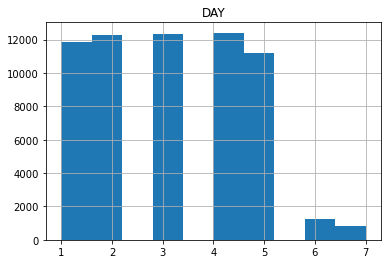

In [32]:
# set time, day, month from OPENING_DATE
df[['HOUR']]= df['Detected on Date'].dt.hour
df[['DAY']]= df['Detected on Date'].dt.dayofweek + 1
df[['MONTH']]= df['Detected on Date'].dt.month
df['OPENING_DAY'] = df['Detected on Date'].dt.day_name().str.upper()
df.hist(column='DAY')


In [33]:
#Add season coloumn
df[['SEASON']]= 4
df['SEASON'] = np.where((df.MONTH > 2) & (df.MONTH < 6), 1, df.SEASON)
df['SEASON'] = np.where((df.MONTH > 5) & (df.MONTH < 9), 2, df.SEASON)
df['SEASON'] = np.where((df.MONTH > 8) & (df.MONTH < 12), 3, df.SEASON)
print(df['SEASON'].value_counts())

1    16788
3    16136
4    14779
2    14505
Name: SEASON, dtype: int64


In [34]:
#Add QUARTER coloumn
df[['QUARTER']]= 1
df['QUARTER'] = np.where((df.MONTH > 3) & (df.MONTH < 7), 2, df.QUARTER)
df['QUARTER'] = np.where((df.MONTH > 6) & (df.MONTH < 10), 3, df.QUARTER)
df['QUARTER'] = np.where((df.MONTH > 9) & (df.MONTH < 13), 4, df.QUARTER)
print(df['QUARTER'].value_counts())

2    15843
1    15805
4    15378
3    15182
Name: QUARTER, dtype: int64


In [35]:
#Add back to school coloumn
df[['BACK_TO_SCHOOL']]= 0
df['BACK_TO_SCHOOL'] = np.where((df.MONTH == 9), 1, df.BACK_TO_SCHOOL)
print(df['BACK_TO_SCHOOL'].value_counts())

0    56563
1     5645
Name: BACK_TO_SCHOOL, dtype: int64


In [36]:
# add weekend
df[['WEEKEND']]= 0
df['WEEKEND'] = np.where((df.DAY == 6) | (df.DAY == 7), 1, df.WEEKEND)
print(df['WEEKEND'].value_counts())

0    60110
1     2098
Name: WEEKEND, dtype: int64


0    34675
1    27533
Name: OLA Violation, dtype: int64


array([[<AxesSubplot:title={'center':'OLA Violation'}>]], dtype=object)

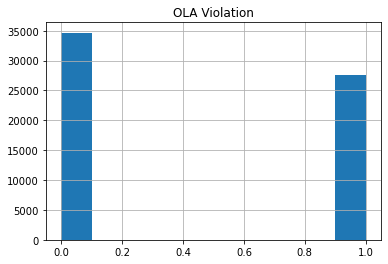

In [37]:
print(df['OLA Violation'].value_counts())
df.hist(column='OLA Violation')

In [38]:
# extract new features from description and summary
# with TF/IDF

In [39]:
#delete stop words
stop_words=pd.read_csv('tr_stop_words.txt', sep=' ', header=None)
stop_words.columns=['tr_stop_words']
pat2 = r'\b(?:{})\b'.format('|'.join(list(stop_words['tr_stop_words'].str.lower())))
df['Description_low'] = df['Description'].str.lower().str.replace(pat2, '')
df.sample(5)

,Actual Fix Time,Defect ID,Description,Status,Closing Date,Defect Main Type,Defect Environment,Defect Type,Detected on Date,Detected on Node,Detected on App,Telco Domain,App. Type,Weekly Defect,Modified,Project Phase,Severity,Summary,OLA Key,OLA,OLA Violation,countDT,HOUR,DAY,MONTH,OPENING_DAY,SEASON,QUARTER,BACK_TO_SCHOOL,WEEKEND,Description_low
20025,22,158882,"Merhaba, 158559 analiz defectinin kurulumu iç...",Closed,2019-03-28,01 - TEST,TEST,Documentation,2019-03-07,[M]BPPS,App52,Mobile,OM,0.653846,2019-03-28 09:42:29,Fonksiyonel,1-Low,158559 Analiz Defecti icin iletilen ODD ile il...,TEST-1-Low,10,1,3754,0,4,3,THURSDAY,1,1,0,0,"merhaba, 158559 analiz defectinin kurulumu i..."
50439,40,101135,Bayi iptal talebi onaylama esnasında aşağıdaki...,Closed,2017-07-05,04 - PRODUCTION,PROD,Analysis,2017-05-27,[M]PRM,App14,Mobile,CRM,0.442308,2017-07-05 08:08:24,Fonksiyonel,2-Medium,Bayi iptal talebi onaylama esnasında alınan hata,PROD-2-Medium,30,1,5234,0,6,5,SATURDAY,1,2,0,1,bayi iptal talebi onaylama aşağıdaki hatayı a...
38432,8,201999,Kontak Kişi: Yavuz Nazlı <yavuz.nazli@partner....,Closed,2020-06-03,04 - PRODUCTION,PROD,Other,2020-05-27,[BB]DWH,App74,Broadband,DWH,0.826923,2020-06-03 14:57:58,Unknown,3-High,Siebel Sub Segment Problemi,PROD-3-High,15,0,220,0,3,5,WEDNESDAY,1,2,0,0,kontak kişi: yavuz nazlı <yavuz.nazli@partner....
50709,59,105801,Bize SD377631 kayıtlı F1 çağırısı ile iletilen...,Closed,2017-09-29,04 - PRODUCTION,PROD,Code,2017-08-02,[M]DWH,App54,Mobile,DWH,3.615385,2017-09-29 08:58:43,Fonksiyonel,2-Medium,Dashboard da raporun eksik veri getirmesi,PROD-2-Medium,30,1,42451,0,3,8,WEDNESDAY,2,3,0,0,sd377631 kayıtlı f1 çağırısı iletilen sorund...
40097,2,215915,"Selamlar,\nTest3 ortamında NT işlemi denendiği...",Closed,2020-10-17,01 - TEST,TEST,Code,2020-10-16,[M]ASB 12.2.1,App6,Mobile,MW,7.711538,2020-10-17 13:24:15,Regresyon,5-Urgent,test3_NT_SAPRETAIL_CheckDealer hatasi,TEST-5-Urgent,2,1,42451,0,5,10,FRIDAY,3,4,0,0,"selamlar,\ntest3 ortamında nt işlemi denendiği..."


In [40]:
# remove punctiation
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
 return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

In [41]:
df['Description_final'] = df['Description_low'].apply(lambda text: remove_punctuation(text)) 
df.sample(5)

,Actual Fix Time,Defect ID,Description,Status,Closing Date,Defect Main Type,Defect Environment,Defect Type,Detected on Date,Detected on Node,Detected on App,Telco Domain,App. Type,Weekly Defect,Modified,Project Phase,Severity,Summary,OLA Key,OLA,OLA Violation,countDT,HOUR,DAY,MONTH,OPENING_DAY,SEASON,QUARTER,BACK_TO_SCHOOL,WEEKEND,Description_low,Description_final
46107,4,223050,"Selamlar,\nATTIP’in TMS’ye geldiği request mes...",Closed,2020-12-25,01 - TEST,TEST,Code,2020-12-22,[F]aTTip,App5,Fixed,MW,4.115385,2020-12-25 14:03:39,Fonksiyonel,2-Medium,364833 hk.,TEST-2-Medium,5,0,42451,0,2,12,TUESDAY,4,4,0,0,"selamlar,\nattip’in tms’ye geldiği request mes...",selamlar\nattip’in tms’ye geldiği request mesa...
32780,16,247433,Cihaz satışı işlemi gerçekleştirirken ekranı k...,Closed,2021-09-16,04 - PRODUCTION,PROD,Code,2021-09-01,[F]OMNI 360(CSR),App56,Fixed,WP,7.557692,2021-09-16 11:27:06,Unknown,2-Medium,Adım Sayısının Yanlış Verilmesi,PROD-2-Medium,30,0,42451,0,3,9,WEDNESDAY,3,3,1,0,cihaz satışı işlemi gerçekleştirirken ekranı k...,cihaz satışı işlemi gerçekleştirirken ekranı k...
49414,18,228166,"Merhabalar,\nPlayer üzerinden favoriye ekleme/...",Closed,2021-03-04,01 - TEST,TEST,Code,2021-02-15,[M]MUUD,App38,Mobile,MBL,9.019231,2021-03-04 10:51:15,Fonksiyonel,2-Medium,IOS_Favori playr botunu hk.,TEST-2-Medium,5,1,42451,0,1,2,MONDAY,4,1,0,0,"merhabalar,\nplayer üzerinden favoriye ekleme/...",merhabalar\nplayer üzerinden favoriye eklemeçı...
45171,35,190486,Merhaba;\n36745736 Flow ID’ li akış Appointme...,Closed,2020-02-25,04 - PRODUCTION,PROD,Code,2020-01-22,[BB]TTNET ESB,App2,Broadband,MW,12.096154,2020-02-25 16:05:13,Fonksiyonel,2-Medium,12C_Satış | [ hizmetNo ] alanına gecersiz veri...,PROD-2-Medium,30,1,42451,0,3,1,WEDNESDAY,4,1,0,0,merhaba;\n36745736 flow id’ li akış appointme...,merhaba\n36745736 flow id’ li akış appointmen...
34630,3,192831,"Selamlar,\nEVH_OVERUSAGE_MAPPING tablosundaki ...",Closed,2020-02-19,01 - TEST,TEST,Code,2020-02-17,[M]BSCS DB,App18,Mobile,BR,4.615385,2020-02-19 13:45:15,Fonksiyonel,2-Medium,EVH_OVERUSAGE_MAPPING Hk,TEST-2-Medium,5,0,42451,0,1,2,MONDAY,4,1,0,0,"selamlar,\nevh_overusage_mapping tablosundaki ...",selamlar\nevhoverusagemapping tablosundaki ben...


In [42]:
# instantiate the vectorizer object
tfidfvectorizer = TfidfVectorizer(analyzer= 'word', stop_words=None)

In [43]:
# convert th documents into a matrix
tfidf_wm = tfidfvectorizer.fit_transform(df['Description_final'])

In [44]:
#retrieve the terms found in the corpora
# if we take same parameters on both Classes(CountVectorizer and TfidfVectorizer) , it will give same output of get_feature_names() methods)
tfidf_tokens = tfidfvectorizer.get_feature_names()
tfidf_values = tfidfvectorizer.idf_

In [45]:
df_tfidf = pd.DataFrame({'token': tfidf_tokens, 'tfidf': list(tfidf_values)}, columns=['token', 'tfidf'])

In [46]:
df_tfidf_words = df_tfidf.loc[~df_tfidf['token'].str.contains('0|1|2|3|4|5|6|7|8|9|aa')]

In [47]:
df_tfidf_words = df_tfidf_words.loc[df_tfidf_words['token'].str.len() < 13]

In [48]:
df_tfidf_words.shape

(93634, 2)

In [49]:
#df_tfidf_words.head

In [50]:
# find meaningful words with low idf score
df_idf_words = df_tfidf_words.loc[df_tfidf_words['tfidf'] < 8]

In [51]:
#4077 words
#df_idf_words

In [52]:
# add new features TF count, extracting from idf scores
# GUI; buton|ekran|combobox|menu|menü|görüntü|gui
# Subscriber; abone|hizmet|teklif|ürün|service|tarife|tariff
# Workflow; akış|süreç|sürec|flow
# Database; veritabanı|database|tablo|field|data 
# Workorder; işemri|workorder| iş emri| work order
# Order; satış|başvuru|sipariş|aktivasyon|nakil|churn
# Device; cihaz|modem|cpe|device
# Integration; web service|web servis|endpoint|metod|entegrasyon|çağrı
# Report; rapor|report
# Customer; customer|müşteri|account|hesap

In [53]:
# GUI; buton|ekran|combobox|menu|menü|görüntü|gui
df['GUI'] = 0
df['GUI'] = np.where(df['Description_final'].str.contains('buton|ekran|combobox|menu|menü|görüntü|gui'), 
                     (((df['Description_final'].str.count('buton')
                      +df['Description_final'].str.count('ekran')
                      +df['Description_final'].str.count('combobox')
                      +df['Description_final'].str.count('menu')
                      +df['Description_final'].str.count('menü')
                      +df['Description_final'].str.count('görüntü')
                      +df['Description_final'].str.count('gui'))
                     /df['Description_final'].str.split().apply(len))*100)
                     , df.GUI)

In [54]:
# Subscriber; abone|hizmet|teklif|ürün|service|tarife|tariff
df['Subscriber'] = 0
df['Subscriber'] = np.where(df['Description_final'].str.contains('abone|hizmet|teklif|ürün|service|tarife|tariff'), 
                     (((df['Description_final'].str.count('abone')
                      +df['Description_final'].str.count('hizmet')
                      +df['Description_final'].str.count('teklif')
                      +df['Description_final'].str.count('ürün')
                      +df['Description_final'].str.count('service')
                      +df['Description_final'].str.count('tarife')
                      +df['Description_final'].str.count('tariff'))
                     /df['Description_final'].str.split().apply(len))*100)
                     , df.Subscriber)

In [55]:
# Workflow; akış|süreç|sürec|flow
df['Workflow'] = 0
df['Workflow'] = np.where(df['Description_final'].str.contains('akış|süreç|sürec|flow'), 
                     (((df['Description_final'].str.count('akış')
                      +df['Description_final'].str.count('süreç')
                      +df['Description_final'].str.count('sürec')
                      +df['Description_final'].str.count('flow'))
                     /df['Description_final'].str.split().apply(len))*100)
                     , df.Workflow)

In [56]:
# Database; veritabanı|database|tablo|field
df['Database'] = 0
df['Database'] = np.where(df['Description_final'].str.contains('veritabanı|database|tablo|table|field'), 
                     (((df['Description_final'].str.count('veritabanı')
                      +df['Description_final'].str.count('database')
                      +df['Description_final'].str.count('tablo')
                      +df['Description_final'].str.count('table')
                      +df['Description_final'].str.count('field'))
                     /df['Description_final'].str.split().apply(len))*100)
                     , df.Database)

In [57]:
# Workorder; işemri|workorder| iş emri| work order
df['Workorder'] = 0
df['Workorder'] = np.where(df['Description_final'].str.contains('işemri|workorder|iş emri|work order'), 
                     (((df['Description_final'].str.count('işemri')
                      +df['Description_final'].str.count('workorder')
                      +df['Description_final'].str.count('iş emri')
                      +df['Description_final'].str.count('work order'))
                     /df['Description_final'].str.split().apply(len))*100)
                     , df.Workorder)

In [58]:
# Order; satış|başvuru|sipariş|aktivasyon|nakil|churn
df['Order'] = 0
df['Order'] = np.where(df['Description_final'].str.contains('satış|başvuru|sipariş|aktivasyon|nakil|churn'), 
                     (((df['Description_final'].str.count('satış')
                      +df['Description_final'].str.count('başvuru')
                      +df['Description_final'].str.count('sipariş')
                      +df['Description_final'].str.count('aktivasyon')
                      +df['Description_final'].str.count('nakil')
                      +df['Description_final'].str.count('churn'))
                     /df['Description_final'].str.split().apply(len))*100)
                     , df.Order)

In [59]:
# Device; cihaz|modem|cpe|device
df['Device'] = 0
df['Device'] = np.where(df['Description_final'].str.contains('cihaz|modem|cpe|device'), 
                     (((df['Description_final'].str.count('cihaz')
                      +df['Description_final'].str.count('modem')
                      +df['Description_final'].str.count('cpe')
                      +df['Description_final'].str.count('device'))
                     /df['Description_final'].str.split().apply(len))*100)
                     , df.Device)

In [60]:
# Integration; web service|web servis|endpoint|metod|entegrasyon|çağrı
df['Integration'] = 0
df['Integration'] = np.where(df['Description_final'].str.contains('web service|web servis|endpoint|end point|metod|entegrasyon|çağrı|call'), 
                     (((df['Description_final'].str.count('web service')
                      +df['Description_final'].str.count('web servis')
                      +df['Description_final'].str.count('endpoint')
                      +df['Description_final'].str.count('end point')
                      +df['Description_final'].str.count('metod')
                      +df['Description_final'].str.count('entegrasyon')
                      +df['Description_final'].str.count('çağrı')
                      +df['Description_final'].str.count('call'))
                     /df['Description_final'].str.split().apply(len))*100)
                     , df.Integration)

In [61]:
# Report; rapor|report
df['Report'] = 0
df['Report'] = np.where(df['Description_final'].str.contains('rapor|report'), 
                     (((df['Description_final'].str.count('rapor')
                      +df['Description_final'].str.count('report'))
                     /df['Description_final'].str.split().apply(len))*100)
                     , df.Report)

In [62]:
# Customer; customer|müşteri|account|hesap
df['Customer'] = 0
df['Customer'] = np.where(df['Description_final'].str.contains('customer|müşteri|account|hesap'), 
                     (((df['Description_final'].str.count('customer')
                      +df['Description_final'].str.count('müşteri')
                      +df['Description_final'].str.count('account')
                      +df['Description_final'].str.count('hesap'))
                     /df['Description_final'].str.split().apply(len))*100)
                     , df.Customer)

In [63]:
df.isnull().sum()

Actual Fix Time       0
Defect ID             0
Description           0
Status                0
Closing Date          0
Defect Main Type      0
Defect Environment    0
Defect Type           0
Detected on Date      0
Detected on Node      0
Detected on App       0
Telco Domain          0
App. Type             0
Weekly Defect         0
Modified              0
Project Phase         0
Severity              0
Summary               0
OLA Key               0
OLA                   0
OLA Violation         0
countDT               0
HOUR                  0
DAY                   0
MONTH                 0
OPENING_DAY           0
SEASON                0
QUARTER               0
BACK_TO_SCHOOL        0
WEEKEND               0
Description_low       0
Description_final     0
GUI                   0
Subscriber            0
Workflow              0
Database              0
Workorder             0
Order                 0
Device                0
Integration           0
Report                0
Customer        

In [64]:
df['Severity'] = np.where(df.Severity == '2-Medium', 2, df.Severity)
df['Severity'] = np.where(df.Severity == '1-Low', 1, df.Severity)
df['Severity'] = np.where(df.Severity == '3-High', 3, df.Severity)
df['Severity'] = np.where(df.Severity == '5-Urgent', 5, df.Severity)
df['Severity'] = np.where(df.Severity == '4-Very High', 4, df.Severity)

In [65]:
# convert ordinal features to one hot encoding
print(df['Defect Main Type'].value_counts())
print(df['Defect Environment'].value_counts())
print(df['Defect Type'].value_counts())
print(df['Telco Domain'].value_counts())
print(df['App. Type'].value_counts())
print(df['Project Phase'].value_counts())
print(df['Severity'].value_counts())
print(df['OLA Key'].value_counts())
print(df['DAY'].value_counts())
print(df['MONTH'].value_counts())
print(df['HOUR'].value_counts())
print(df['OPENING_DAY'].value_counts())
print(df['SEASON'].value_counts())
print(df['QUARTER'].value_counts())

01 - TEST             43926
04 - PRODUCTION       14145
02 - UAT               3000
03 - PREPRODUCTION     1137
Name: Defect Main Type, dtype: int64
TEST    48063
PROD    14145
Name: Defect Environment, dtype: int64
Code             42451
Analysis          5234
Documentation     3754
Other             3053
Configuration     2555
Design            1902
System            1775
GUI               1484
Name: Defect Type, dtype: int64
Mobile       23969
Fixed        21409
Broadband    16830
Name: Telco Domain, dtype: int64
OM     19658
WP      8355
MW      7930
BR      7877
OTH     7237
CRM     3230
DWH     1965
ERP     1915
MBL     1103
WFM     1049
COL      780
MSJ      606
PM       448
DOC       55
Name: App. Type, dtype: int64
Fonksiyonel    36866
Unknown        14014
Regresyon       7422
Entegrasyon     2340
Demo            1518
Security          48
Name: Project Phase, dtype: int64
2    27030
1    17688
3    14469
5     1620
4     1401
Name: Severity, dtype: int64
TEST-2-Medium       19

In [66]:
ohe_defect_mtype = pd.get_dummies(df['Defect Main Type'], prefix='DMT')
ohe_defect_environment = pd.get_dummies(df['Defect Environment'], prefix='DE')
ohe_defect_type = pd.get_dummies(df['Defect Type'], prefix='DT')
ohe_telco_domain = pd.get_dummies(df['Telco Domain'], prefix='TD')
ohe_app_type = pd.get_dummies(df['App. Type'], prefix='AT')
ohe_project_phase = pd.get_dummies(df['Project Phase'], prefix='PP')
ohe_MONTH = pd.get_dummies(df['MONTH'], prefix='MONTH')
ohe_OPENING_DAY = pd.get_dummies(df['DAY'], prefix='DAY')
ohe_SEASON = pd.get_dummies(df['SEASON'], prefix='SEASON')
ohe_QUARTER = pd.get_dummies(df['QUARTER'], prefix='QUARTER')

In [67]:
df_hot = pd.concat([df, ohe_defect_mtype, ohe_defect_environment, ohe_defect_type, ohe_telco_domain, ohe_app_type, ohe_project_phase
                    , ohe_MONTH, ohe_OPENING_DAY, ohe_SEASON, ohe_QUARTER]
                   , axis=1)

df_hot.head()

,Actual Fix Time,Defect ID,Description,Status,Closing Date,Defect Main Type,Defect Environment,Defect Type,Detected on Date,Detected on Node,Detected on App,Telco Domain,App. Type,Weekly Defect,Modified,Project Phase,Severity,Summary,OLA Key,OLA,OLA Violation,countDT,HOUR,DAY,MONTH,OPENING_DAY,SEASON,QUARTER,BACK_TO_SCHOOL,WEEKEND,Description_low,Description_final,GUI,Subscriber,Workflow,Database,Workorder,Order,Device,Integration,Report,Customer,DMT_01 - TEST,DMT_02 - UAT,DMT_03 - PREPRODUCTION,DMT_04 - PRODUCTION,DE_PROD,DE_TEST,DT_Analysis,DT_Code,DT_Configuration,DT_Design,DT_Documentation,DT_GUI,DT_Other,DT_System,TD_Broadband,TD_Fixed,TD_Mobile,AT_BR,AT_COL,AT_CRM,AT_DOC,AT_DWH,AT_ERP,AT_MBL,AT_MSJ,AT_MW,AT_OM,AT_OTH,AT_PM,AT_WFM,AT_WP,PP_Demo,PP_Entegrasyon,PP_Fonksiyonel,PP_Regresyon,PP_Security,PP_Unknown,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,DAY_1,DAY_2,DAY_3,DAY_4,DAY_5,DAY_6,DAY_7,SEASON_1,SEASON_2,SEASON_3,SEASON_4,QUARTER_1,QUARTER_2,QUARTER_3,QUARTER_4
0,15,119912,C90986 id'li change'te yer alan fee_update_v1....,Closed,2018-01-26,04 - PRODUCTION,PROD,Analysis,2018-01-12,[M]BSCS DB,App18,Mobile,BR,4.615385,2018-01-26 09:13:38,Fonksiyonel,2,FEE-UPDATE - Valid_From hatası,PROD-2-Medium,30,0,5234,0,5,1,FRIDAY,4,1,0,0,c90986 id'li change'te yer alan fee_update_v1....,c90986 idli changete yer alan feeupdatev1sqlin...,0.000000,3.846154,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0
1,7,126747,EU_BPM.FreeDeactAllCommitmentByReason paketi c...,Closed,2018-04-10,03 - PREPRODUCTION,TEST,Analysis,2018-04-04,[M]BSCS DB,App18,Mobile,BR,4.615385,2018-04-10 14:02:56,Unknown,1,EU_BPM.FreeDeactAllCommitmentByReason_Create,TEST-1-Low,10,0,5234,0,3,4,WEDNESDAY,1,2,0,0,eu_bpm.freedeactallcommitmentbyreason paketi c...,eubpmfreedeactallcommitmentbyreason paketi cre...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
2,37,127973,eu_bpm.last_cutoff_invoice_info paketinde null...,Closed,2018-05-24,04 - PRODUCTION,PROD,Analysis,2018-04-18,[M]BSCS DB,App18,Mobile,BR,4.615385,2018-05-24 10:32:51,Fonksiyonel,2,eu_bpm.last_cutoff_invoice_info paketinde tari...,PROD-2-Medium,30,1,5234,0,3,4,WEDNESDAY,1,2,0,0,eu_bpm.last_cutoff_invoice_info paketinde null...,eubpmlastcutoffinvoiceinfo paketinde null değ...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
3,28,186500,"Selamlar,\nOpera'dan mernis güncellenmesi sonr...",Closed,2020-01-06,01 - TEST,TEST,Code,2019-12-10,[M]Siebel CC,App12,Mobile,CRM,1.846154,2020-01-07 16:46:24,Fonksiyonel,5,Test1_ABCS_SIEBEL_CUSTOMER_OPERATIONS_Merns_le...,TEST-5-Urgent,2,1,42451,0,2,12,TUESDAY,4,4,0,0,"selamlar,\nopera'dan mernis güncellenmesi sonr...",selamlar\noperadan mernis güncellenmesi sonras...,0.000000,1.694915,0.0,1.694915,0.0,0.0,0.0,0.000000,0.0,3.389831,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
4,12,146872,"Merhaba,\nTarafınızdan yapılan aşağıdaki incel...",Closed,2018-11-23,04 - PRODUCTION,PROD,Analysis,2018-11-12,[M]BSCS Workaraound,App112,Mobile,OTH,0.576923,2018-11-23 08:19:12,Fonksiyonel,2,EU_BILL.DEACTIVATE_BLACKSNCODES procedure'u h...,PROD-2-Medium,30,0,5234,0,1,11,MONDAY,3,4,0,0,"merhaba,\ntarafınızdan aşağıdaki incelemeye ...",merhaba\ntarafınızdan aşağıdaki incelemeye d...,0.877193,9.649123,0.0,0.877193,0.0,0.0,0.0,0.877193,0.0,0.000000,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [68]:
# Find the correlation between features (hints: pearson correlation)
df_hot.corr(method="pearson")

,Actual Fix Time,Defect ID,Weekly Defect,OLA,OLA Violation,countDT,HOUR,DAY,MONTH,SEASON,QUARTER,BACK_TO_SCHOOL,WEEKEND,GUI,Subscriber,Workflow,Database,Workorder,Order,Device,Integration,Report,Customer,DMT_01 - TEST,DMT_02 - UAT,DMT_03 - PREPRODUCTION,DMT_04 - PRODUCTION,DE_PROD,DE_TEST,DT_Analysis,DT_Code,DT_Configuration,DT_Design,DT_Documentation,DT_GUI,DT_Other,DT_System,TD_Broadband,TD_Fixed,TD_Mobile,AT_BR,AT_COL,AT_CRM,AT_DOC,AT_DWH,AT_ERP,AT_MBL,AT_MSJ,AT_MW,AT_OM,AT_OTH,AT_PM,AT_WFM,AT_WP,PP_Demo,PP_Entegrasyon,PP_Fonksiyonel,PP_Regresyon,PP_Security,PP_Unknown,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,DAY_1,DAY_2,DAY_3,DAY_4,DAY_5,DAY_6,DAY_7,SEASON_1,SEASON_2,SEASON_3,SEASON_4,QUARTER_1,QUARTER_2,QUARTER_3,QUARTER_4
Actual Fix Time,1.000000,-0.020895,-0.089422,0.380100,0.447230,-0.110164,NaN,0.025754,-0.023266,-0.016131,-0.022993,-0.009910,-0.014912,-0.051473,0.014462,-0.035755,0.006092,-0.022304,-0.026779,-0.007335,-0.012174,0.010213,-0.011848,-0.387772,0.017805,0.046802,0.397388,0.397388,-0.397388,0.187813,-0.113668,-0.069914,0.083048,-0.077616,-0.005071,0.036191,0.070854,-0.087404,-0.046150,0.124837,0.058721,-0.009558,0.034333,0.004824,0.031685,0.004828,0.070717,-0.008580,-0.080061,-0.058778,0.047109,-0.023183,-0.025433,0.008995,-0.027675,0.007724,0.012310,-0.097058,0.037307,0.065055,0.012306,-0.003507,0.002351,-0.005520,0.009883,0.006894,0.028192,0.021954,-0.009910,-0.029080,-0.024283,-0.006388,-0.015557,-0.019026,0.001395,0.007826,0.033013,-0.009131,-0.012145,0.004159,0.035765,-0.040274,0.001604,0.007100,0.006944,0.024231,-0.038304
Defect ID,-0.020895,1.000000,0.077923,0.017682,-0.046848,0.060196,NaN,0.012310,0.082647,-0.001712,0.075870,0.095946,0.020781,-0.015621,-0.042341,0.005611,-0.000434,-0.025844,-0.010704,0.005884,-0.003144,0.031603,-0.026198,0.011429,0.067464,-0.066376,-0.025692,-0.025692,0.025692,-0.018142,0.058462,-0.053519,-0.024278,0.023405,0.047962,-0.074069,-0.025651,-0.047651,0.046701,-0.002093,-0.026135,0.028220,-0.091012,0.008099,0.011673,0.032285,0.147099,0.001038,0.017827,-0.132861,0.065509,-0.012686,-0.103681,0.139633,0.061416,0.102661,0.233565,0.087244,-0.009479,-0.411206,-0.051609,-0.042446,-0.031265,-0.046527,-0.037410,0.018427,0.044427,0.063589,0.095946,0.003591,0.015272,-0.031180,0.001548,-0.001422,-0.012661,-0.005547,0.009020,0.003694,0.027767,-0.074152,0.080196,0.074948,-0.079524,-0.079538,-0.043038,0.131485,-0.007184
Weekly Defect,-0.089422,0.077923,1.000000,-0.183832,0.026907,0.164675,NaN,0.000996,0.021851,-0.000148,0.022986,0.006173,0.011413,0.100676,0.002929,0.043868,-0.059026,-0.018695,0.213527,0.032177,0.064820,-0.084236,0.123636,0.172047,0.043482,-0.063952,-0.188775,-0.188775,0.188775,-0.120412,0.164840,0.006221,-0.082693,0.011118,-0.012242,-0.075000,-0.089430,0.640251,-0.301057,-0.290540,-0.115562,-0.075209,-0.106622,-0.029474,-0.129067,-0.145257,0.024840,-0.064219,0.237193,0.384148,-0.335941,-0.065084,-0.104458,-0.026429,-0.013011,0.002156,-0.009164,0.089754,-0.017616,-0.053870,-0.008467,-0.012881,-0.014581,0.002056,-0.007017,0.007666,-0.001082,0.005319,0.006173,0.003807,0.027296,-0.008871,0.002583,0.000298,-0.003776,-0.001037,-0.003316,0.011621,0.003731,-0.012689,0.007747,0.023986,-0.019164,-0.023076,0.001657,0.006917,0.014727
OLA,0.380100,0.017682,-0.183832,1.000000,-0.215353,-0.255314,NaN,-0.000581,-0.038402,-0.009374,-0.038169,-0.021945,-0.012244,-0.105973,0.022561,-0.017464,0.051616,-0.000018,-0.071819,-0.031422,-0.019742,0.066270,-0.037598,-0.721819,-0.101234,-0.061401,0.855871,0.855871,-0.855871,0.335754,-0.261915,-0.089810,0.167315,-0.091478,-0.018770,0.031833,0.213330,-0.100862,0.042328,0.050749,0.066532,-0.003860,0.059458,-0.003065,0.139293,0.204254,-0.042163,-0.007283,-0.067484,-0.097934,0.019380,0.002162,-0.032437,-0.065526,-0.011810,0.012266,0.116077,-0.156427,0.037948,-0.018893,0.019320,0.013731,0.005811,0.010516,0.023883,0.003265,-0.002587,-0.012092,-0.021945,-0.025698,-0.013969,0.000358,-0.000585,-0.00

In [69]:
df_hot.columns

Index(['Actual Fix Time', 'Defect ID', 'Description', 'Status', 'Closing Date',
       'Defect Main Type', 'Defect Environment', 'Defect Type',
       'Detected on Date', 'Detected on Node',
       ...
       'DAY_6', 'DAY_7', 'SEASON_1', 'SEASON_2', 'SEASON_3', 'SEASON_4',
       'QUARTER_1', 'QUARTER_2', 'QUARTER_3', 'QUARTER_4'],
      dtype='object', length=106)

In [70]:
df_features=df_hot
df_features.shape

(62208, 106)

In [71]:
df_features.isnull().sum()

Actual Fix Time           0
Defect ID                 0
Description               0
Status                    0
Closing Date              0
Defect Main Type          0
Defect Environment        0
Defect Type               0
Detected on Date          0
Detected on Node          0
Detected on App           0
Telco Domain              0
App. Type                 0
Weekly Defect             0
Modified                  0
Project Phase             0
Severity                  0
Summary                   0
OLA Key                   0
OLA                       0
OLA Violation             0
countDT                   0
HOUR                      0
DAY                       0
MONTH                     0
OPENING_DAY               0
SEASON                    0
QUARTER                   0
BACK_TO_SCHOOL            0
WEEKEND                   0
Description_low           0
Description_final         0
GUI                       0
Subscriber                0
Workflow                  0
Database            

In [105]:
all_features = df_features[[
               'DAY_1', 'DAY_2', 'DAY_3', 'DAY_4', 'DAY_5', 'DAY_6', 'DAY_7' 
             , 'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12'
             , 'SEASON_1', 'SEASON_2', 'SEASON_3', 'SEASON_4'
             , 'QUARTER_1', 'QUARTER_2', 'QUARTER_3', 'QUARTER_4'
             , 'Weekly Defect', 'Severity', 'OLA'
             , 'BACK_TO_SCHOOL', 'WEEKEND' 
             , 'GUI', 'Subscriber', 'Workflow', 'Database', 'Workorder', 'Order', 'Device', 'Integration', 'Report', 'Customer'
             , 'DMT_01 - TEST', 'DMT_02 - UAT', 'DMT_03 - PREPRODUCTION', 'DMT_04 - PRODUCTION'
             , 'DE_PROD', 'DE_TEST'
             , 'DT_Analysis', 'DT_Code', 'DT_Configuration', 'DT_Design', 'DT_Documentation', 'DT_GUI', 'DT_Other', 'DT_System'
             , 'TD_Broadband', 'TD_Fixed', 'TD_Mobile'
             , 'AT_BR', 'AT_COL', 'AT_CRM', 'AT_DOC', 'AT_DWH', 'AT_ERP', 'AT_MBL', 'AT_MSJ', 'AT_MW', 'AT_OM', 'AT_OTH', 'AT_PM', 'AT_WFM', 'AT_WP'
             , 'PP_Demo', 'PP_Entegrasyon', 'PP_Fonksiyonel', 'PP_Regresyon', 'PP_Security', 'PP_Unknown'
             , 'OLA Violation']]

best_features = df_features[[
               'DAY_1', 'DAY_2', 'DAY_3', 'DAY_4', 'DAY_5', 'DAY_6', 'DAY_7' 
             #, 'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12'
             #, 'SEASON_1', 'SEASON_2', 'SEASON_3', 'SEASON_4'
             #, 'QUARTER_1', 'QUARTER_2', 'QUARTER_3', 'QUARTER_4'
             , 'Weekly Defect', 'Severity', 'OLA'
             #, 'BACK_TO_SCHOOL', 'WEEKEND' 
             , 'GUI', 'Order', 'Customer', 'Subscriber'
             #, 'Workflow', 'Database', 'Workorder', 'Integration', 'Report', 'Device'
             , 'DMT_01 - TEST', 'DMT_02 - UAT', 'DMT_03 - PREPRODUCTION', 'DMT_04 - PRODUCTION'
             #, 'DE_PROD', 'DE_TEST'
             , 'DT_Analysis', 'DT_Code', 'DT_Configuration', 'DT_Design', 'DT_Documentation', 'DT_GUI', 'DT_Other', 'DT_System'
             , 'TD_Broadband', 'TD_Fixed', 'TD_Mobile'
             , 'AT_BR', 'AT_COL', 'AT_CRM', 'AT_DOC', 'AT_DWH', 'AT_ERP', 'AT_MBL', 'AT_MSJ', 'AT_MW', 'AT_OM', 'AT_OTH', 'AT_PM', 'AT_WFM', 'AT_WP'
             , 'PP_Demo', 'PP_Entegrasyon', 'PP_Fonksiyonel', 'PP_Regresyon', 'PP_Security', 'PP_Unknown'
             , 'OLA Violation']]

all_core_features = df_features[[
               'DAY_1', 'DAY_2', 'DAY_3', 'DAY_4', 'DAY_5', 'DAY_6', 'DAY_7' 
             , 'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12'
             , 'SEASON_1', 'SEASON_2', 'SEASON_3', 'SEASON_4'
             , 'QUARTER_1', 'QUARTER_2', 'QUARTER_3', 'QUARTER_4'
             , 'Weekly Defect', 'Severity', 'OLA'
             , 'BACK_TO_SCHOOL', 'WEEKEND' 
             #, 'GUI', 'Subscriber', 'Workflow', 'Database', 'Workorder', 'Order', 'Device', 'Integration', 'Report', 'Customer'
             , 'DMT_01 - TEST', 'DMT_02 - UAT', 'DMT_03 - PREPRODUCTION', 'DMT_04 - PRODUCTION'
             , 'DE_PROD', 'DE_TEST'
             , 'DT_Analysis', 'DT_Code', 'DT_Configuration', 'DT_Design', 'DT_Documentation', 'DT_GUI', 'DT_Other', 'DT_System'
             , 'TD_Broadband', 'TD_Fixed', 'TD_Mobile'
             , 'AT_BR', 'AT_COL', 'AT_CRM', 'AT_DOC', 'AT_DWH', 'AT_ERP', 'AT_MBL', 'AT_MSJ', 'AT_MW', 'AT_OM', 'AT_OTH', 'AT_PM', 'AT_WFM', 'AT_WP'
             , 'PP_Demo', 'PP_Entegrasyon', 'PP_Fonksiyonel', 'PP_Regresyon', 'PP_Security', 'PP_Unknown'
             , 'OLA Violation']]

In [106]:
# set features for training
features = ''
#features = all_features
#features = best_features
features = all_core_features

features.head()
features.shape

(62208, 70)

In [107]:
features.head()

,DAY_1,DAY_2,DAY_3,DAY_4,DAY_5,DAY_6,DAY_7,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,SEASON_1,SEASON_2,SEASON_3,SEASON_4,QUARTER_1,QUARTER_2,QUARTER_3,QUARTER_4,Weekly Defect,Severity,OLA,BACK_TO_SCHOOL,WEEKEND,DMT_01 - TEST,DMT_02 - UAT,DMT_03 - PREPRODUCTION,DMT_04 - PRODUCTION,DE_PROD,DE_TEST,DT_Analysis,DT_Code,DT_Configuration,DT_Design,DT_Documentation,DT_GUI,DT_Other,DT_System,TD_Broadband,TD_Fixed,TD_Mobile,AT_BR,AT_COL,AT_CRM,AT_DOC,AT_DWH,AT_ERP,AT_MBL,AT_MSJ,AT_MW,AT_OM,AT_OTH,AT_PM,AT_WFM,AT_WP,PP_Demo,PP_Entegrasyon,PP_Fonksiyonel,PP_Regresyon,PP_Security,PP_Unknown,OLA Violation
0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,4.615385,2,30,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,4.615385,1,10,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,4.615385,2,30,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1.846154,5,2,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0.576923,2,30,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [108]:
# drop duplicates rows
# but no dublicate
features.drop_duplicates()
features.shape

(62208, 70)

In [109]:
features.columns

Index(['DAY_1', 'DAY_2', 'DAY_3', 'DAY_4', 'DAY_5', 'DAY_6', 'DAY_7',
       'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6',
       'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12',
       'SEASON_1', 'SEASON_2', 'SEASON_3', 'SEASON_4', 'QUARTER_1',
       'QUARTER_2', 'QUARTER_3', 'QUARTER_4', 'Weekly Defect', 'Severity',
       'OLA', 'BACK_TO_SCHOOL', 'WEEKEND', 'DMT_01 - TEST', 'DMT_02 - UAT',
       'DMT_03 - PREPRODUCTION', 'DMT_04 - PRODUCTION', 'DE_PROD', 'DE_TEST',
       'DT_Analysis', 'DT_Code', 'DT_Configuration', 'DT_Design',
       'DT_Documentation', 'DT_GUI', 'DT_Other', 'DT_System', 'TD_Broadband',
       'TD_Fixed', 'TD_Mobile', 'AT_BR', 'AT_COL', 'AT_CRM', 'AT_DOC',
       'AT_DWH', 'AT_ERP', 'AT_MBL', 'AT_MSJ', 'AT_MW', 'AT_OM', 'AT_OTH',
       'AT_PM', 'AT_WFM', 'AT_WP', 'PP_Demo', 'PP_Entegrasyon',
       'PP_Fonksiyonel', 'PP_Regresyon', 'PP_Security', 'PP_Unknown',
       'OLA Violation'],
      dtype='object')

In [110]:
# find null values
features.isnull().sum()

DAY_1                     0
DAY_2                     0
DAY_3                     0
DAY_4                     0
DAY_5                     0
DAY_6                     0
DAY_7                     0
MONTH_1                   0
MONTH_2                   0
MONTH_3                   0
MONTH_4                   0
MONTH_5                   0
MONTH_6                   0
MONTH_7                   0
MONTH_8                   0
MONTH_9                   0
MONTH_10                  0
MONTH_11                  0
MONTH_12                  0
SEASON_1                  0
SEASON_2                  0
SEASON_3                  0
SEASON_4                  0
QUARTER_1                 0
QUARTER_2                 0
QUARTER_3                 0
QUARTER_4                 0
Weekly Defect             0
Severity                  0
OLA                       0
BACK_TO_SCHOOL            0
WEEKEND                   0
DMT_01 - TEST             0
DMT_02 - UAT              0
DMT_03 - PREPRODUCTION    0
DMT_04 - PRODUCTION 

In [111]:
#Draw heatmap example
#cm=features.corr(method="pearson")
#sns.set(font_scale=0.6)
#hm=sns.heatmap(cm, cbar=True,annot=True,square=True)

In [112]:
# set inputs and outputs
#x = features.iloc[:,0:14].values # all features
#x = features.iloc[:,0:6].values # RFC features
x = features.iloc[:,0:(features.columns.size-1)].values # nominal or ordinal features
y = features.iloc[:,-1].values

In [113]:
# Split the data to training and test sets
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=147)

In [114]:
# Print the number of instances in training & test set
x_train.shape

(49766, 69)

In [115]:
y_train.shape

(49766,)

In [116]:
x_test.shape

(12442, 69)

In [117]:
#y_train, y_test class distrubitions
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

{0: 27778, 1: 21988}
{0: 6897, 1: 5545}


In [118]:
# scale train data
scaler=StandardScaler()
x_std=scaler.fit_transform(x)

In [119]:
# StandardScaler
scaler=StandardScaler()

In [120]:
# scale train data
x_train_std=scaler.fit_transform(x_train)

In [121]:
x_train_std

array([[-0.48525335, -0.49380061, -0.49911445, ...,  2.72330144,
        -0.02727696, -0.53920861],
       [-0.48525335, -0.49380061, -0.49911445, ...,  2.72330144,
        -0.02727696, -0.53920861],
       [-0.48525335, -0.49380061,  2.00354849, ..., -0.36720136,
        -0.02727696,  1.85456978],
       ...,
       [-0.48525335, -0.49380061,  2.00354849, ..., -0.36720136,
        -0.02727696, -0.53920861],
       [ 2.06077916, -0.49380061, -0.49911445, ..., -0.36720136,
        -0.02727696, -0.53920861],
       [-0.48525335, -0.49380061, -0.49911445, ..., -0.36720136,
        -0.02727696, -0.53920861]])

In [122]:
# Scale each feature to range(0, 1)
x_test_std=scaler.transform(x_test)
x_test_std

array([[-0.48525335,  2.02510889, -0.49911445, ..., -0.36720136,
        -0.02727696, -0.53920861],
       [-0.48525335, -0.49380061, -0.49911445, ..., -0.36720136,
        -0.02727696, -0.53920861],
       [-0.48525335, -0.49380061, -0.49911445, ..., -0.36720136,
        -0.02727696, -0.53920861],
       ...,
       [-0.48525335,  2.02510889, -0.49911445, ..., -0.36720136,
        -0.02727696, -0.53920861],
       [-0.48525335, -0.49380061, -0.49911445, ..., -0.36720136,
        -0.02727696, -0.53920861],
       [-0.48525335, -0.49380061,  2.00354849, ..., -0.36720136,
        -0.02727696, -0.53920861]])

In [123]:
##################################
# define the hard voting ensemble
##################################
print("Finish/Start: ", datetime.now())
modelWeights = [1,1,1,1,1,1,1] 
myModel = VotingClassifier(estimators=getModels(), weights=modelWeights, voting='hard')

Finish/Start:  2021-12-19 18:29:22.208710


In [124]:
myModel.fit(x_train_std,y_train)

[19:12:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('RFC',
                              RandomForestClassifier(bootstrap=False,
                                                     criterion='entropy',
                                                     max_depth=10,
                                                     min_samples_split=5,
                                                     n_estimators=800,
                                                     random_state=0)),
                             ('MLP',
                              MLPClassifier(activation='tanh', alpha=0.01,
                                            max_iter=2000, random_state=0,
                                            solver='sgd')),
                             ('LR',
                              LogisticRegression(C=0.01, penalty='l1',
                                                 random_state=0,
                                                 solver='liblinear')),
                             ('KNN',
         

              precision    recall  f1-score   support

         OLA       0.73      0.76      0.75      6897
   Violation       0.69      0.65      0.67      5545

    accuracy                           0.71     12442
   macro avg       0.71      0.71      0.71     12442
weighted avg       0.71      0.71      0.71     12442

Accuracy:  0.7132293843433531
MSE: 0.28677061565664685
RMSE: 0.5355096783968025
R2: -0.16078895268561388
MEA: 0.28677061565664685


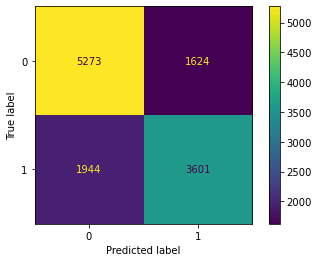

In [125]:
predictResults(myModel, x_test_std, y_test, 0)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       min_samples_split=5, n_estimators=800, random_state=0)
Accuracy: 0.7017360552965761
              precision    recall  f1-score   support

         OLA       0.73      0.74      0.73      6897
   Violation       0.67      0.66      0.66      5545

    accuracy                           0.70     12442
   macro avg       0.70      0.70      0.70     12442
weighted avg       0.70      0.70      0.70     12442

MLPClassifier(activation='tanh', alpha=0.01, max_iter=2000, random_state=0,
              solver='sgd')
Accuracy: 0.6908053367625784
              precision    recall  f1-score   support

         OLA       0.71      0.74      0.73      6897
   Violation       0.66      0.63      0.64      5545

    accuracy                           0.69     12442
   macro avg       0.69      0.68      0.69     12442
weighted avg       0.69      0.69      0.69     12442

LogisticRegression(C=0.01, pena

<Figure size 720x720 with 0 Axes>

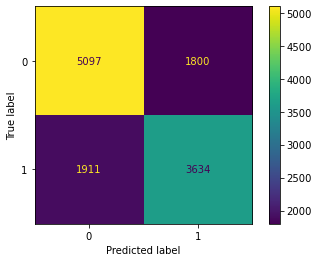

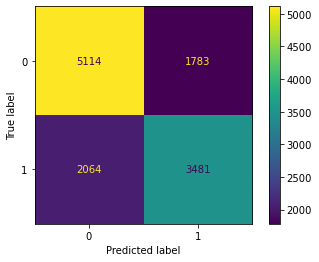

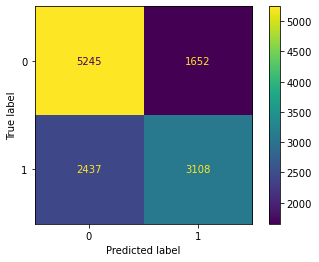

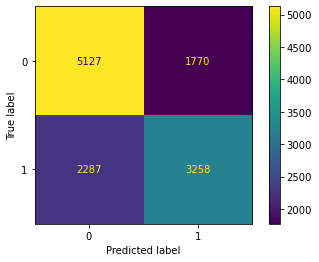

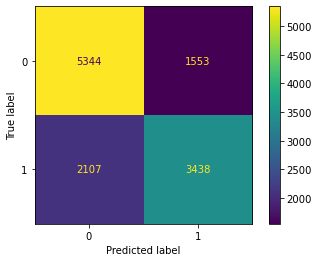

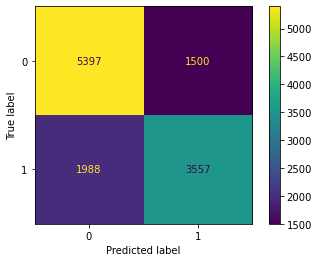

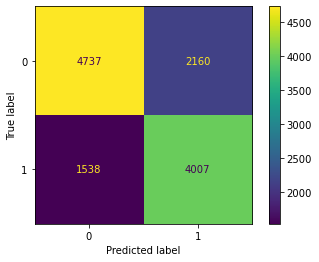

In [126]:
#model scores
voting_model_scores(myModel, x_test_std, y_test)

                   Feature  Feature Importance
29                     OLA          661.271406
27           Weekly Defect          647.066953
28                Severity          389.240703
4                    DAY_5          219.068202
48               TD_Mobile          181.048548
57                   AT_MW          164.061529
3                    DAY_4          161.028103
53                  AT_DWH          155.040870
66            PP_Regresyon          146.031597
55                  AT_MBL          119.072895
47                TD_Fixed           92.039574
62                   AT_WP           87.026716
1                    DAY_2           78.024771
68              PP_Unknown           77.026938
0                    DAY_1           75.023960
54                  AT_ERP           73.030574
34  DMT_03 - PREPRODUCTION           63.026493
14                 MONTH_8           61.017882
32           DMT_01 - TEST           60.033279
10                 MONTH_4           59.020117
35     DMT_04

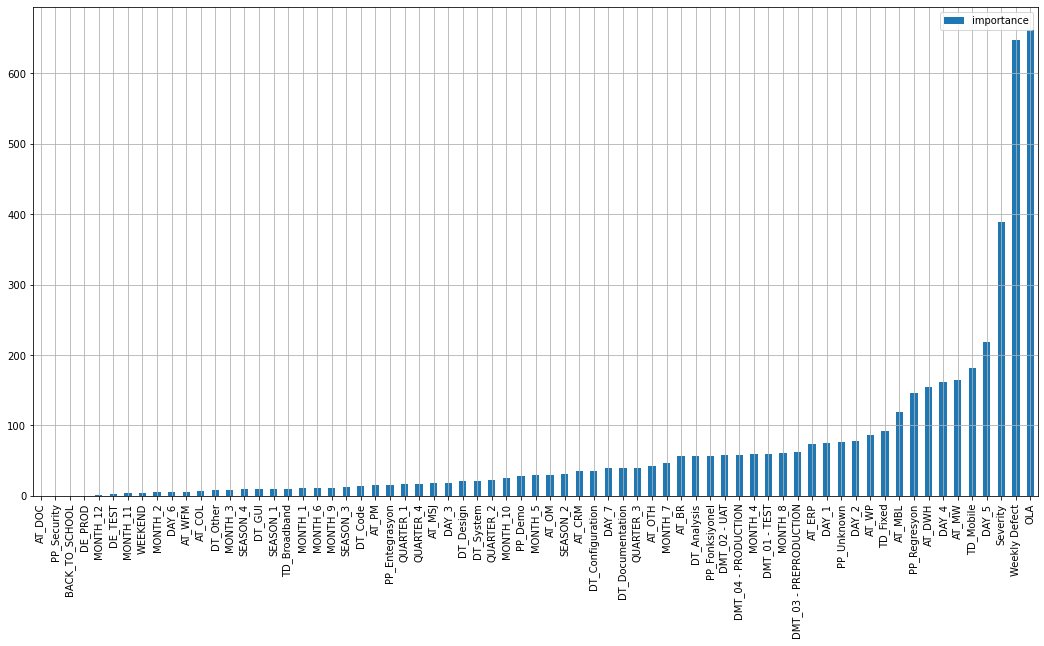

In [127]:
compute_feature_importance(myModel, features.iloc[:,0:(features.columns.size-1)], modelWeights)

                   Feature  Feature Importance
28                Severity            0.537425
4                    DAY_5            0.191614
55                  AT_MBL            0.174521
48               TD_Mobile            0.171204
34  DMT_03 - PREPRODUCTION            0.129512
33            DMT_02 - UAT            0.107606
3                    DAY_4            0.091812
62                   AT_WP            0.085079
13                 MONTH_7            0.069465
27           Weekly Defect            0.046917
38             DT_Analysis            0.036894
59                  AT_OTH            0.036809
14                 MONTH_8            0.032431
65          PP_Fonksiyonel            0.027398
41               DT_Design            0.022486
11                 MONTH_5            0.019726
37                 DE_TEST            0.006408
58                   AT_OM            0.003913
7                  MONTH_1            0.003538
52                  AT_DOC            0.001745
44           

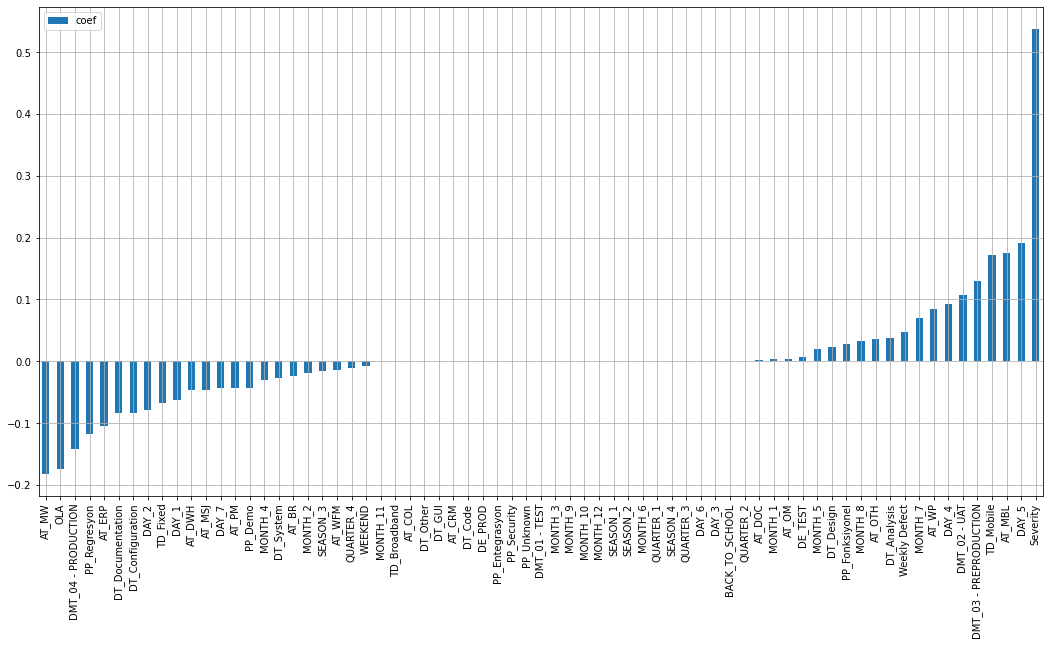

In [128]:
compute_feature_coef(myModel, features.iloc[:,0:(features.columns.size-1)], modelWeights)

In [129]:
####################################### 
print("Start/Finish: ", datetime.now())

Start/Finish:  2021-12-19 19:20:51.069992


In [130]:
##########################
#10 fold cross validation
##########################

In [131]:
print("Finish/Start: ", datetime.now())
modelWeights = [1,1,1,1,1,1,1] 
myModel = VotingClassifier(estimators=getModels(), weights=modelWeights, voting='hard')

Finish/Start:  2021-12-19 19:20:51.104990


In [132]:
myModel = xFoldCrossValidation(myModel, x_std, y, 10)

Recall: 0.647 (0.004)


In [137]:
votingModelsCrossValidation(getClsModels(), x_std, y, 10)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       min_samples_split=5, n_estimators=800, random_state=0)
Recall: 0.648 (0.007)
MLPClassifier(activation='tanh', alpha=0.01, max_iter=2000, random_state=0,
              solver='sgd')
Recall: 0.622 (0.005)
LogisticRegression(C=0.01, penalty='l1', random_state=0, solver='liblinear')
Recall: 0.553 (0.009)
KNeighborsClassifier(metric='manhattan', weights='distance')
Recall: 0.586 (0.009)
SVC(C=1, probability=True, random_state=0)
Recall: 0.616 (0.007)
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.5, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.06, max_delta_step=None, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=900, n_jobs=None, num_parallel_tree=None,
              random

In [ ]:
####################################### 
print("Start/Finish: ", datetime.now())

In [ ]:
##########################################
# GRID SEARCH and RANDOM SEARCH FOR MODELS
##########################################

In [ ]:
#default performances

In [ ]:
#default performances
print("RandomForestClassifier")    
myModel=RandomForestClassifier(random_state=0)
myModel.fit(x_train_std,y_train)
predictResults(myModel, x_test_std, y_test, 0)

print("MLPClassifier")    
myModel=MLPClassifier(random_state= 0)
myModel.fit(x_train_std,y_train)
predictResults(myModel, x_test_std, y_test, 0)

print("LogisticRegression")    
myModel=LogisticRegression(random_state = 0)
myModel.fit(x_train_std,y_train)
predictResults(myModel, x_test_std, y_test, 0)

print("KNeighborsClassifier")    
myModel=KNeighborsClassifier()
myModel.fit(x_train_std,y_train)
predictResults(myModel, x_test_std, y_test, 0)

print("SVC")    
myModel=SVC(random_state=0)
myModel.fit(x_train_std,y_train)
predictResults(myModel, x_test_std, y_test, 0)

print("XGBClassifier")    
myModel=XGBClassifier(random_state=0)
myModel.fit(x_train_std,y_train)
predictResults(myModel, x_test_std, y_test, 0)

print("LGBMClassifier")    
myModel=LGBMClassifier(random_state=0)
myModel.fit(x_train_std,y_train)
predictResults(myModel, x_test_std, y_test, 0)

In [ ]:
#LogisticRegression Grid Search
# define search space
parameter_space = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10, 100],
    'random_state': [0]
}
gridSearch(LogisticRegression(), parameter_space, x_train_std, y_train, 'recall')

In [86]:
#KNeighborsClassifier Random Search
# define search space
parameter_space = {
    'n_neighbors': list(range(3, 22, 2)),
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance'],
    'leaf_size': list(range(20, 41, 5)),
    'p': [1, 2]
}                        
randomSearch(KNeighborsClassifier(), parameter_space, x_train_std, y_train, 'recall', 50)

Start:  2021-11-28 23:48:21.868110
Best Score: 0.5733434407759449
Best Hyperparameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 3, 'metric': 'manhattan', 'leaf_size': 30}
End:  2021-11-29 05:46:46.203117
0.671 0.539 for {'weights': 'uniform', 'p': 2, 'n_neighbors': 19, 'metric': 'manhattan', 'leaf_size': 35}
0.640 0.558 for {'weights': 'uniform', 'p': 2, 'n_neighbors': 3, 'metric': 'euclidean', 'leaf_size': 25}
0.667 0.544 for {'weights': 'uniform', 'p': 1, 'n_neighbors': 15, 'metric': 'minkowski', 'leaf_size': 25}
0.665 0.530 for {'weights': 'distance', 'p': 2, 'n_neighbors': 21, 'metric': 'minkowski', 'leaf_size': 35}
0.660 0.571 for {'weights': 'distance', 'p': 1, 'n_neighbors': 5, 'metric': 'minkowski', 'leaf_size': 25}
0.664 0.568 for {'weights': 'distance', 'p': 1, 'n_neighbors': 7, 'metric': 'minkowski', 'leaf_size': 40}
0.671 0.539 for {'weights': 'uniform', 'p': 1, 'n_neighbors': 19, 'metric': 'manhattan', 'leaf_size': 35}
0.660 0.567 for {'weights': 'uniform', 'p': 2, 

In [87]:
#SVC Random Search
parameter_space = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'random_state': [0]
}                        
randomSearch(SVC(), parameter_space, x_train_std, y_train, 'recall', 10)

Start:  2021-11-29 05:46:46.218740
Best Score: 0.6070737270904979
Best Hyperparameters: {'random_state': 0, 'kernel': 'poly', 'gamma': 'scale', 'C': 10}
End:  2021-12-02 13:06:50.866526
0.700 0.603 for {'random_state': 0, 'kernel': 'rbf', 'gamma': 'auto', 'C': 1}
0.669 0.532 for {'random_state': 0, 'kernel': 'linear', 'gamma': 'auto', 'C': 1}
0.676 0.607 for {'random_state': 0, 'kernel': 'poly', 'gamma': 'scale', 'C': 10}
0.669 0.533 for {'random_state': 0, 'kernel': 'linear', 'gamma': 'auto', 'C': 0.01}
0.684 0.531 for {'random_state': 0, 'kernel': 'rbf', 'gamma': 'scale', 'C': 0.1}
0.624 0.524 for {'random_state': 0, 'kernel': 'sigmoid', 'gamma': 'auto', 'C': 0.1}
0.669 0.532 for {'random_state': 0, 'kernel': 'linear', 'gamma': 'auto', 'C': 10}
0.624 0.524 for {'random_state': 0, 'kernel': 'sigmoid', 'gamma': 'scale', 'C': 0.1}
0.700 0.603 for {'random_state': 0, 'kernel': 'rbf', 'gamma': 'scale', 'C': 1}
0.676 0.607 for {'random_state': 0, 'kernel': 'poly', 'gamma': 'auto', 'C': 10}

In [88]:
#XGBClassifier random Search
parameter_space = {
    'n_estimators': stats.randint(150, 1000),
    'learning_rate': stats.uniform(0.01, 0.59),
    'subsample': stats.uniform(0.3, 0.6),
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'colsample_bytree': stats.uniform(0.5, 0.4),
    'min_child_weight': [1, 2, 3, 4],
    'use_label_encoder': [False],
    'random_state': [0]
}                        
randomSearch(XGBClassifier(), parameter_space, x_train_std, y_train, 'recall', 50)

Start:  2021-12-02 13:06:50.931682
[01:57:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Score: 0.6386064653150446
Best Hyperparameters: {'colsample_bytree': 0.5786329446720214, 'learning_rate': 0.22754785068996883, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 406, 'random_state': 0, 'subsample': 0.6737076573280016, 'use_label_encoder': False}
End:  2021-12-03 01:57:39.781308
0.695 0.634 for {'colsample_bytree': 0.7195254015709299, 'learning_rate': 0.4319617261597275, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 857, 'random_state': 0, 'subsample': 0.8083510432704752, 'use_label_encoder': False}
0.689 0.630 for {'colsample_bytree': 0.7494254787143889, 'learning_rate': 0.2367852073026929, 'max_depth': 9, 'min_c

In [89]:
#RFC Random Search
space = dict()
space['criterion'] = ['entropy', 'gini']
space['random_state'] =  [0]
space['n_estimators'] = range(100, 1001, 100)
# Number of features to consider at every split
space['max_features'] = ['auto', 'log2', None] 
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
space['max_depth'] = max_depth 
# Minimum number of samples required to split a node
space['min_samples_split'] = [2, 5, 10] 
# Minimum number of samples required at each leaf node
space['min_samples_leaf'] = [1, 2, 4] 
# Method of selecting samples for training each tree
space['bootstrap'] = [True, False]
parameter_space = space                        
randomSearch(RandomForestClassifier(), parameter_space, x_train_std, y_train, 'recall', 50)

Start:  2021-12-03 14:53:39.508938
Best Score: 0.6391367336436461
Best Hyperparameters: {'random_state': 0, 'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'gini', 'bootstrap': True}
End:  2021-12-04 14:26:50.725104
0.714 0.632 for {'random_state': 0, 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 110, 'criterion': 'entropy', 'bootstrap': True}
0.665 0.579 for {'random_state': 0, 'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 40, 'criterion': 'gini', 'bootstrap': False}
0.691 0.626 for {'random_state': 0, 'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'gini', 'bootstrap': False}
0.694 0.639 for {'random_state': 0, 'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'c

In [90]:
#MLP random Search
#define search space
parameter_space = {
    'max_iter': range(200, 2001, 100),
    'random_state': [0],
    'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.05],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
}                        
randomSearch(MLPClassifier(), parameter_space, x_train_std, y_train, 'recall', 50)

Start:  2021-12-04 14:26:50.850074
Best Score: 0.6132284258582259
Best Hyperparameters: {'solver': 'sgd', 'random_state': 0, 'max_iter': 700, 'learning_rate': 'constant', 'hidden_layer_sizes': (50, 50, 50), 'alpha': 0.0001, 'activation': 'relu'}
End:  2021-12-05 23:05:06.524462
0.663 0.610 for {'solver': 'adam', 'random_state': 0, 'max_iter': 1900, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50, 50, 50), 'alpha': 0.001, 'activation': 'logistic'}
0.668 0.606 for {'solver': 'lbfgs', 'random_state': 0, 'max_iter': 700, 'learning_rate': 'constant', 'hidden_layer_sizes': (50, 100, 50), 'alpha': 0.01, 'activation': 'logistic'}
0.640 0.592 for {'solver': 'adam', 'random_state': 0, 'max_iter': 600, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (50, 100, 50), 'alpha': 0.001, 'activation': 'tanh'}
0.659 0.611 for {'solver': 'sgd', 'random_state': 0, 'max_iter': 1000, 'learning_rate': 'constant', 'hidden_layer_sizes': (50, 100, 50), 'alpha': 0.05, 'activation': 'relu'}
0.639 0.589 

T:\Umit\tools\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.
  warnings.warn(


In [91]:
#LGBMClassifier random Search
#define search space
parameter_space = {
    'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
    'num_leaves': list(range(1,51,2)),
    'max_depth': list(range(-1,101,5)),
    'learning_rate': stats.uniform(0.01, 1),
    'n_estimators': stats.randint(100, 1000),
    'class_weight': ['dict', 'balanced', None],
    'min_child_samples': list(range(10,101,10)),
    'random_state': [0],
    'importance_type': ['split','gain']
}                        
randomSearch(LGBMClassifier(), parameter_space, x_train_std, y_train, 'recall', 50)

Start:  2021-12-05 23:05:08.161445
Best Score: 0.7125556285200363
Best Hyperparameters: {'boosting_type': 'dart', 'class_weight': 'balanced', 'importance_type': 'split', 'learning_rate': 0.22745049270557183, 'max_depth': 79, 'min_child_samples': 10, 'n_estimators': 766, 'num_leaves': 7, 'random_state': 0}
End:  2021-12-05 23:45:55.199385
0.698 0.692 for {'boosting_type': 'gbdt', 'class_weight': 'balanced', 'importance_type': 'split', 'learning_rate': 0.6127633760716439, 'max_depth': 14, 'min_child_samples': 80, 'n_estimators': 109, 'num_leaves': 39, 'random_state': 0}
0.708 0.626 for {'boosting_type': 'dart', 'class_weight': None, 'importance_type': 'split', 'learning_rate': 0.3075346065444723, 'max_depth': 59, 'min_child_samples': 20, 'n_estimators': 586, 'num_leaves': 15, 'random_state': 0}
nan nan for {'boosting_type': 'rf', 'class_weight': None, 'importance_type': 'split', 'learning_rate': 0.40278479610082973, 'max_depth': 64, 'min_child_samples': 90, 'n_estimators': 877, 'num_leav